In [1]:
import numpy as np
import networkx as nx
import qiskit_aer as Aer

from qiskit import execute, transpile
from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeCairoV2, FakeJohannesburg
from qiskit.providers.aer.noise import NoiseModel

from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

from utils import *
from ibm_utils import *

In [2]:

#Generate random circuit 10 for each number of qubit from 10-20
# n_depth = 20
# for i in range(21, 34):
#     for j in range(10):
#         qasm_dir = f"tst/n{i}/rg_circuit_n{i}_{j}.qasm"
#         qc = generate_random_circuit(i, n_depth, save_file_dir=qasm_dir )


In [2]:
# sycamore_graph = generate_ibm_tokyo_topology_graph()


[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
[(0, 1), (0, 5), (1, 2), (1, 6), (1, 7), (2, 3), (2, 7), (2, 6), (3, 4), (3, 8), (3, 9), (4, 9), (4, 8), (5, 6), (5, 10), (5, 11), (6, 7), (6, 11), (6, 10), (7, 8), (7, 12), (7, 13), (8, 9), (8, 13), (8, 12), (9, 14), (10, 11), (10, 15), (11, 12), (11, 16), (11, 17), (12, 13), (12, 17), (12, 16), (13, 14), (13, 18), (13, 19), (14, 19), (14, 18), (15, 16), (16, 17), (17, 18), (18, 19)]


In [16]:
#get quantum circuit
# qc = QuantumCircuit.from_qasm_file('tst/qaoa_n6_transpiled.qasm')
#set grid topology size
row = 5
col = 4


#Use random circuit
# n_qubits = 20
# n_depths = 20
# qasm_dir = f"tst/n{n_qubits}_d{n_depths}.qasm"
# # qc = generate_random_circuit(n_qubits, n_depths, save_file_dir=qasm_dir)
# qc = QuantumCircuit.from_qasm_file(qasm_dir)

#Use benchmark circuit
# qasm_dir = f"QASMBench/medium/qf21_n15/qf21_n15_transpiled.qasm"
# qasm_dir = f"QASMBench/small/qpe_n9/qpe_n9_transpiled.qasm"
# /home/hok/Projects/square_mapping/QASMBench/medium/qec9xz_n17/qec9xz_n17_transpiled.qasm
# QASMBench/medium/ghz_state_n23/ghz_state_n23_transpiled.qasm
# qasm_dir = "QASMBench/medium/bigadder_n18/bigadder_n18_transpiled.qasm"
# qasm_dir = "QASMBench/medium/qram_n20/qram_n20_transpiled.qasm"
# qasm_dir = f"QASMBench/medium/qec9xz_n17/qec9xz_n17_transpiled.qasm"
# qasm_dir = f"QASMBench/medium/multiplier_n15/multiplier_n15_transpiled.qasm"
# QASMBench/small/adder_n10/adder_n10_transpiled.qasm

qasm_dir = "QASMBench/medium/factor247_n15/factor247_n15.qasm"


#/home/hok/Projects/square_mapping/QASMBench/small/qpe_n9/qpe_n9_transpiled.qasm
qc = QuantumCircuit.from_qasm_file(qasm_dir)

exact_result = ibm_executor(circuit=qc.copy(),
                            cmap=None,
                            optimization_level=0,
                            noise_level=0.0,
                            init_layout=None)
print(exact_result)

#convert qc to nxgraph
qc_graph = qc_to_nxgraph(qc)

#draw quantum circuit graph
# nx.draw(qc_graph)
nx.draw_networkx(qc_graph)

KeyboardInterrupt: 

In [102]:
sorted_edge = sorted(qc_graph.edges(data=True), key=lambda edge: edge[2]['weight'], reverse=True)
sorted_edge

[(0, 2, {'weight': 6}),
 (1, 6, {'weight': 6}),
 (2, 3, {'weight': 6}),
 (3, 4, {'weight': 6}),
 (4, 5, {'weight': 6}),
 (6, 7, {'weight': 6}),
 (7, 8, {'weight': 6}),
 (8, 9, {'weight': 6}),
 (0, 10, {'weight': 5}),
 (1, 14, {'weight': 5}),
 (2, 10, {'weight': 5}),
 (2, 11, {'weight': 5}),
 (3, 11, {'weight': 5}),
 (3, 12, {'weight': 5}),
 (4, 12, {'weight': 5}),
 (4, 13, {'weight': 5}),
 (5, 13, {'weight': 5}),
 (6, 14, {'weight': 5}),
 (6, 15, {'weight': 5}),
 (7, 15, {'weight': 5}),
 (7, 16, {'weight': 5}),
 (8, 16, {'weight': 5}),
 (8, 17, {'weight': 5}),
 (9, 17, {'weight': 5}),
 (0, 9, {'weight': 1}),
 (1, 5, {'weight': 1})]

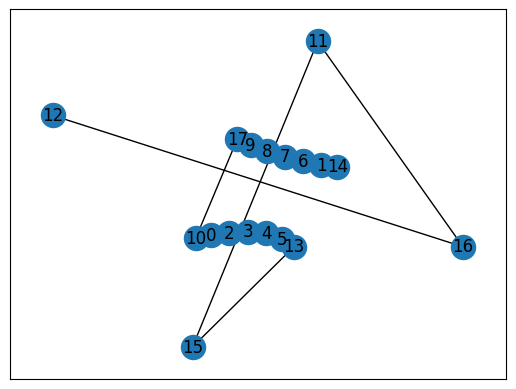

In [111]:
#convert to spanning tree graph
# qc_spgraph = nx.maximum_spanning_tree(qc_graph)
qc_spgraph = max_edges_spanning_tree(qc_graph)
#draw quantum circuit spanning tree graph
nx.draw_networkx(qc_spgraph)

In [104]:
#initial coupling map
# cmap_graph = generate_custom_coupling_map(qc_spgraph, qc_graph, col, row)

#generate grid matrix to find adjacency node
grid_matrix = generate_grid_matrix(row, col, qc_spgraph)

In [6]:
# coupling_map.draw()

In [93]:
grid_matrix

array([[12, 16, 11, 15],
       [ 3,  4,  5, 13],
       [ 2,  0, 10, 17],
       [ 6,  7,  8,  9],
       [ 1, 14, -1, -1]])

In [105]:
cmap_graph = connect_adjacent_and_diagonal_edge(grid_matrix, qc_spgraph, qc_graph)
print(cmap_graph.edges)

[(0, 2), (0, 10), (1, 6), (1, 14), (2, 3), (3, 4), (3, 12), (4, 5), (4, 12), (5, 13), (6, 7), (6, 14), (7, 8), (8, 9), (8, 17), (9, 17), (10, 17), (11, 16), (11, 15), (12, 16), (13, 15)]


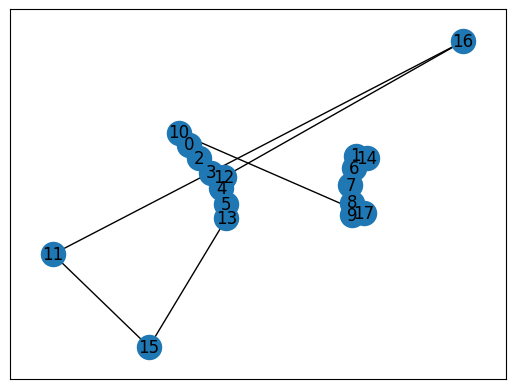

In [106]:
nx.draw_networkx(cmap_graph)

In [107]:
print(grid_matrix)

21
[[12 16 11 15]
 [ 3  4  5 13]
 [ 2  0 10 17]
 [ 6  7  8  9]
 [ 1 14 -1 -1]]


In [109]:
cmap = eliminate_diagonal_edges_with_constraints(grid_matrix, cmap_graph)
print(len(cmap_graph.edges))
cmap_graph.edges

20


EdgeView([(0, 2), (0, 10), (1, 6), (1, 14), (2, 3), (3, 4), (3, 12), (4, 5), (4, 12), (5, 13), (6, 7), (7, 8), (8, 9), (8, 17), (9, 17), (10, 17), (11, 16), (11, 15), (12, 16), (13, 15)])

In [98]:

cmap = generate_custom_coupling_map(cmap_graph)
# nx.draw_networkx(coupling_map)
# coupling_map.edges()

ValueError: Could not save to JPEG for display

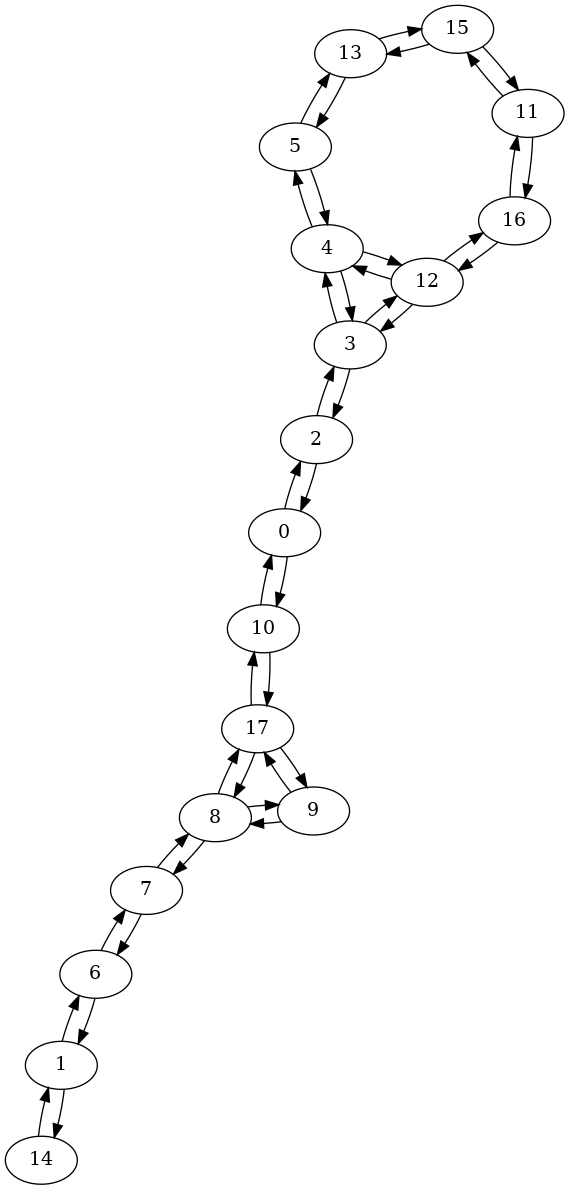

In [99]:

cmap.draw()

In [100]:
print(grid_matrix)
print(cmap.neighbors(7))

[[12 16 11 15]
 [ 3  4  5 13]
 [ 2  0 10 17]
 [ 6  7  8  9]
 [ 1 14 -1 -1]]
NodeIndices[8, 6]


In [60]:

backend = Aer.get_backend("qasm_simulator")
fake_backend = FakeAlmadenV2()


#use fake_backend basis gate for decomposition
# config = fake_backend.configuration()
basis_gates = backend.configuration().basis_gates

noise_model = initialized_depolarizing_noise(noise_level=0.05)

In [13]:
#Exact result
# exact = execute(qc.copy(),
#                  backend=backend)
# exact.result().get_counts()

In [61]:
# job = execute(
#     experiments= qc,
#     backend=backend,
#     optimization_level=0,
#     coupling_map=coupling_map,
#     noise_model = noise_model
# )
# job.result().get_counts()

init_layout = {}
for i in range(len(qc.qubits)):
    init_layout[i] = qc.qubits[i]

#apply initial layout
transpiled_ReT = transpile(
    circuits=qc,
    backend=backend,
    basis_gates=basis_gates,
    coupling_map=cmap,
    # initial_layout=init_layout,
)

# result_ReT = execute(transpiled_ReT,
#                      backend= backend,
#                      coupling_map=cmap,
#                      noise_model=noise_model,
#                      optimization_level=0)

ValueError: Could not save to JPEG for display

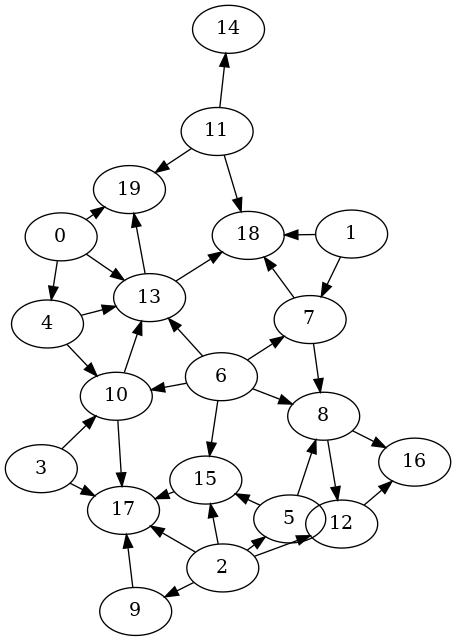

In [11]:
# cmap.draw()

In [12]:
cmap.make_symmetric()


ValueError: Could not save to JPEG for display

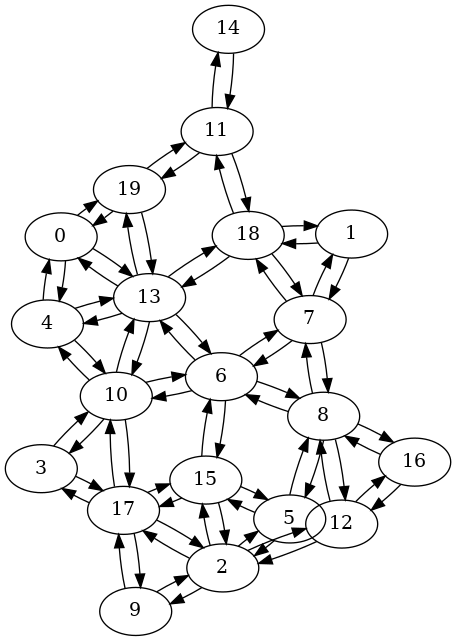

In [13]:
cmap.draw()

In [15]:
# result_ReT.result().get_counts()

In [62]:
print(cmap.physical_qubits)

NodeIndices[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [63]:


transpiled_almaden = transpile(
    circuits=qc,
    backend=fake_backend,
    coupling_map=fake_backend.coupling_map,
    basis_gates=basis_gates,
    # noise_model = noise_model
)

In [64]:
print(f"Original Quantum Circuit Gate Count")
print(qc.count_ops())

print("\nReT Quantum Circuit Gate Count")
print(transpiled_ReT.count_ops())

print("\nFakeAlmaden Quantum Circuit Gate Count")
print(transpiled_almaden.count_ops())

Original Quantum Circuit Gate Count
OrderedDict([('rz', 119), ('cx', 92), ('sx', 14), ('x', 5), ('measure', 1)])

ReT Quantum Circuit Gate Count
OrderedDict([('cx', 92), ('rz', 91), ('swap', 49), ('u2', 14), ('x', 5), ('barrier', 1), ('measure', 1)])

FakeAlmaden Quantum Circuit Gate Count
OrderedDict([('cx', 92), ('rz', 91), ('swap', 44), ('u2', 14), ('x', 5), ('barrier', 1), ('measure', 1)])
